In [181]:
#----------------------------------------------
#             MOUNT GOOGLE DRIVE    
#----------------------------------------------  
from google.colab import drive
drive.mount('/content/drive')
#----------------------------------------------
#           PRINT FILES IN DIRECTORY 
#----------------------------------------------
!ls "/content/drive/My Drive"
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 10-0031-02_Glossa_B-Dimotikou_Tetradio-Ergasion-T1.pdf
 aaaaaaaaa.pdf
 algorithms.zip
 balanced-multi-5.pkl
 balanced-user_cloth_rating.pkl
'Book report (1).gdoc'
'Book report.gdoc'
 clothes_attr.pkl
 clothes_content.pkl
'Colab Notebooks'
 dataset.csv
 dataset_pro.csv
 dataset_pro.gsheet
 decisiontrees.drawio
 Drawio
 DT2008-0099.doc
 final2.csv
 final.csv
 final.gsheet
 id_db.pkl
 images
 mae_item_output.png
 mae_output.png
 mae_svd_output.png
 ml-latest-small
 model
 models
 multi_5-preprocessed.pkl
 multi-user10.pkl
 multi-user5.pkl
 multiuser-preprocessed.pkl
 NewData.csv
 NewData.gsheet
 output2.png
 output.png
 project_Emotion
'python bootcamp'
 rmse_item_output.png
 rmse_svd_output.png
 singleuser5-preprocessed.pkl
 singleuser-preprocessed.pkl
'Software development proposal.gdoc'
 sw_matrix.pkl
 sw_user_item_rating.pkl
 test
'Untitled document.gdoc'
 

# **`data_handler.py`**


---



In [182]:
# import all libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
''' 
@author: Mpountou
@year: 2020
'''
 
class data_handler:
  """
    A class to handle and preprocess data before make recommendation
    ...
    
    Attributes
    ----------
    path : str
       location directory file of data 
    columns : array
       array of columns that should keep from data 
    
    Methods
    -------
    loadDataFrame()
       retruns dataframe based on path and columns
    deep_preprocessing()
       returns dataframe for deep learning model based, total users, total items and minmax of ratings
    split()
       splits the data given the user input 
    create_matrix()
       creates a user - item matrix given the user item dataframe 
  
    """ 
  def __init__(self,path,columns):
    # make path global
    self.path = path
    # make cols global
    self.columns = columns

  def loadDataFrame(self):
    # generate dataframe - user,item,rating
    dataset = pd.read_pickle(self.path)

    # return data with declared columns
    return dataset[self.columns]

  def deep_preprocessing(self,dataset):
    # init encoder
    encoder = LabelEncoder()
    # create new data frame for deep learning model
    df = pd.DataFrame(columns=dataset.columns)
    # user encode
    df[columns[0]] = encoder.fit_transform(dataset[columns[0]].values)
    # get num of total users
    t_users = df[columns[0]].nunique()
    # init encoder
    itemencoder = LabelEncoder()
    # item encode
    df[columns[1]] = itemencoder.fit_transform(dataset[columns[1]].values)
    # get num of total items
    t_items = df[columns[1]].nunique()
    # typecast rating to float
    df[columns[2]] = dataset[columns[2]].values.astype(np.float32)
    # find min and max of ratings
    minmax = (min(df[columns[2]]),max(df[columns[2]]))

    # return dataframe,total users, total items, and min-max of ratings
    return df,t_users,t_items,minmax,itemencoder

  def split(self,df,input_user,test_size):
    # get ratings of input user
    input_user_data = df.loc[df[self.columns[0]] == input_user]
    # split ratings to test and train
    train_X, test_X, train_y, test_y = train_test_split(input_user_data, input_user_data.index.tolist(), test_size=test_size, random_state=1)
    # copy all data
    tmp_dataset = df.copy()
    # remove test data
    tmp_dataset.loc[test_X.index.tolist(),self.columns[2]] = -1
    # keep all data except of test data 
    tmp_dataset = tmp_dataset.loc[tmp_dataset[self.columns[2]] >=0]
    # declare train data
    train_X = tmp_dataset
    
    # return train and test data
    return train_X,test_X

  def rec_split(self,df):
    train_X, test_X, train_y, test_y = train_test_split(df, df.index.tolist(), test_size=0.01, random_state=1)
     # return train and test data
    return train_X,test_X

  def create_matrix(dataset,columns,fill_unrated_with):
    # unique value of every user
    users = dataset[columns[0]].unique()
    # number of total users
    t_users = len(users)
    # unique value of every items
    items = dataset[columns[1]].unique()
    items.sort()
    # number of total items
    t_items = len(items)
    # initialize data with zeros
    data = np.empty((t_users,t_items))
    data[:] = fill_unrated_with
    # create user - item matrix
    matrix = pd.DataFrame(data= data,columns=items)

    # fill user-item matrix with ratings
    for user in range(len(users)):
      # current user dataframe
      user_ = dataset.loc[dataset[columns[0]] == users[user]]
      # every item id that user rated
      itemID = user_[columns[1]].tolist()
      # every rating for every item that user rated
      ratingValue = user_[columns[2]].tolist()
      for j in range(len(itemID)):
        # fill ratings on user-item matrix
        matrix[itemID[j]][user] =  ratingValue[j]  

    # return user-item matrix
    return matrix
  


# load data

In [183]:
path = '/content/drive/My Drive/user_cloth_rating.pkl'
#path = '/content/drive/My Drive/sw_user_item_rating.pkl'
columns = ['userId','clothId','rating']
handler = data_handler(path,columns)
dataset = handler.loadDataFrame()
dataset = dataset.reset_index()
dataset = dataset.drop(columns='index')
dataset

,userId,clothId,rating
0,0,1,5.0
1,0,3,3.0
2,0,4,4.5
3,0,8,4.5
4,0,9,3.5
...,...,...,...
21586,9,4308,0.5
21587,9,4310,3.5
21588,9,4313,0.5
21589,9,4314,0.5


# **`cf_userbased.py`**


---



In [186]:
# import all libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
''' 
@author: Mpountou
@year: 2020
'''
 
class cf_userbased:
  """
    A class to make collaborative user based recommendations
    ...
    
    Attributes
    ----------
    input_user : int
       number of userId
    max_neighbors : array
       number of neighbors used for collaborative filtering
    matrix : 2d-array
       a user - item with ratings matrix

    Methods
    -------
    common_ratings()
       retruns the indexes of common ratings given of two users
    user_similarities()
       returns dataframe for deep learning model based, total users, total items and minmax of ratings
    split_and_predict()
       splits the data to train and test and predicts the test  
    """ 
  def __init__(self,dataset,columns,input_user,max_neighbors):
    self.dataset = dataset
    self.columns = columns
    self.input_user = input_user
    self.max_neighbors = max_neighbors

  def common_ratings(self,rA,rB):
    # rating index of userA
    iA = np.nonzero(rA)[0]
    # rating index of userB
    iB = np.nonzero(rB)[0]
    # common index of two users
    ci = set(iA) & set(iB)
    return list(ci)

  def user_similarities(self,matrix):
    # all users expect input_user
    compared_user = matrix.index.tolist()
   
    compared_user.remove(self.input_user)
    # user correlations
    similarities = []
    # total common ratings
    t_common = []
    for i in range(len(compared_user)):
      # get input_user ratings 
      listA = np.array(matrix.loc[self.input_user].tolist())
      # get compared_user ratings
      listB = np.array(matrix.loc[compared_user[i]].tolist())
      # get all common index ratings 
      common_index = self.common_ratings(listA,listB)
      # if common ratings are more than 2 calculate similarity
      if len(common_index) >=2:
        # save total common ratings
        t_common.append(len(common_index))
        # save similarity between input_user and compared_user
        similarities.append(pearsonr(listA[common_index],listB[common_index])[0])
        #similarities.append(cosine_similarity([listA[common_index]],[listB[common_index]])[0][0])
      else:
        # save 1 and not 0 because of division errors
        t_common.append(1)
        # not enough common ratings ~ zero similarity
        similarities.append(0)

    # mean value of common ratings 
    mean_common = np.mean(t_common)
    # discount similarity
    discount_cor = []
 
    # calculate discounts for every similarity
    for i in range(len(similarities)):
      cor = similarities[i] * ( min(mean_common,t_common[i]) / mean_common )
      discount_cor.append(cor)

    # convert to numpy
    discount_cor = np.array(discount_cor)
    # index of best similarities
    best_index = np.argsort(discount_cor)[::-1][:len(discount_cor)]
    # convert to numpy
    compared_user = np.array(compared_user)
    # find users with best similarity
    best_users = compared_user[best_index[:self.max_neighbors]]
    # find scores of users with best similarity
    best_scores = discount_cor[best_index[:self.max_neighbors]]

    return best_users,best_scores

 
  def recommend(self,itemsToPredict):
    # create matrix without test data
    matrix = data_handler.create_matrix(self.dataset,self.columns,fill_unrated_with=0)
    available_data = matrix.columns
    #for i in range(len(itemsToPredict)):
    #  if itemsToPredict[i] not in available_data:
    #    itemsToPredict.remove(itemsToPredict[i])
    
    best_users,best_scores = self.user_similarities(matrix)
    
    c,pred = self.predict(matrix,best_users,best_scores,itemsToPredict)
    df = pd.DataFrame()
    df[self.columns[1]] = c
    df['ub_pred'] = pred
    
    for i in range(len(itemsToPredict)):
      
      if itemsToPredict[i] not in c:
        itemId = itemsToPredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.columns[1],'ub_pred']))

    return df

  def split_and_predict(self,test_split_size):
    if self.max_neighbors <=0:
      print('Neighbor number must be larger than 0')
      return -1,-1
    # split data to train and test set
    train,test = handler.split(self.dataset,self.input_user,test_split_size)
    train_X = pd.DataFrame(train[self.columns[:3]])
    train_y = train[self.columns[2]].tolist()
    test_X = test[self.columns[:3]]
    test_y = test[self.columns[2]].tolist()
 
    # create matrix without test data
    matrix = data_handler.create_matrix(train,self.columns,fill_unrated_with=0)
    # find most similar users
    best_users,best_scores = self.user_similarities(matrix)
    common_predict_items,pred = self.predict(matrix,best_users,best_scores,test_X[self.columns[1]])

    # dataframe with pred ratings
    df1 = pd.DataFrame()
    df1[columns[1]] = common_predict_items
    pred = list(map(lambda x: round(x,2),pred))
    df1['y_pred'] = pred

    # data frame with true ratings
    df2 = test_X.loc[test_X[self.columns[1]].isin(common_predict_items)][[self.columns[1],self.columns[2]]]
    df2 = df2.rename(columns={"rating": "y_true"})

    # data frame with both pred and true ratings
    df = pd.merge(df1,df2,'inner',on=self.columns[1])

    return df

  def predict(self,matrix,best_users,best_scores,itemsToPredict):
    common_indexes = set(np.nonzero(matrix.loc[best_users[0]].tolist())[0])
    # find common ratings for all neighbors
    if self.max_neighbors >1:
      for i in range(1,len(best_users)):
        common_indexes = common_indexes & set(np.nonzero(matrix.loc[best_users[i]].tolist())[0])

    # find  ratings vector for input user
    input_user_index = np.array(matrix.loc[self.input_user].tolist())
    
    # find unrated items
    input_user_index = np.where(input_user_index == 0)[0]
    
    # find items that input user not rated and compared users rated
    common_indexes = common_indexes & set(input_user_index)
    
    # convert to list
    common_indexes = list(common_indexes)

    # common items
    common_items = np.array(matrix.columns.tolist())[common_indexes]

    # predict test items
    common_predict_items = list(set(common_items) & set(itemsToPredict))

    # average ratings of all compared users
    mean_compared_users = []
    for i in range(len(best_users)):
      ratings = np.array(matrix.loc[best_users[i]].tolist())
      index_rating = np.nonzero(ratings)[0]
      mean_compared_users.append(np.mean(ratings[index_rating]))
    
    # index of input user ratings
    ratings = np.array(matrix.loc[self.input_user].tolist())
    index_rating = np.nonzero(ratings)[0]
    
    # average ratings of input user
    mean_input_user = np.mean(ratings[index_rating])
    
    # pred ratings will be saved here
    pred = []

    # for all common ratings
    for i in range(len(common_predict_items)):
      # find all grades for specific item
      grades = []
      for k in range(len(best_users)):
        grades.append(matrix[common_predict_items[i]][best_users[k]])
      # length of ratings
      totalGrades = len(grades)
      weighted_grades = []
      sum1 = 0
      sum2 = 0
      # calculate weighted grade
      for j in range(totalGrades):
        weighted_grades.append(grades[j] -mean_compared_users[j])
        sum1 += weighted_grades[j] * best_scores[j]
        sum2 += best_scores[j]
      pred.append(mean_input_user + sum1/sum2)
    return common_predict_items,pred

  def hyb_eval(self,train,test):
    # create matrix without test data
    matrix = data_handler.create_matrix(train,self.columns,fill_unrated_with=0)
    available_data = matrix.columns
 
    itemsToPredict = test[self.columns[1]].tolist()
 
    best_users,best_scores = self.user_similarities(matrix)
 
    c,pred = self.predict(matrix,best_users,best_scores,itemsToPredict)
 
    df = pd.DataFrame()
    df[self.columns[1]] = c
    df['ub_pred'] = pred
 
    for i in range(len(itemsToPredict)):
      if itemsToPredict[i] not in c:
        itemId = itemsToPredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.columns[1],'ub_pred']))
    return df

  def coverage(self):
    # get all id items
    all_items = [i for i in range(4325)]#self.dataset[self.columns[1]].unique()
    # get rated user items
    rated_items = self.dataset.loc[ self.dataset[self.columns[0]] == self.input_user][self.columns[1]].tolist()
    # get unrated
    unrated_items = list ( set(all_items)  - set(rated_items) )
    # recommend
    df  = self.recommend(unrated_items)
    low_rated = len(df.loc[df['ub_pred'] < 3])
    high_rated = len(df.loc[df['ub_pred'] >= 3])
    unrated = len(unrated_items)
  
    
    cov_df = pd.DataFrame()
    cov_df['high_rated'] = [high_rated]
    cov_df['low_rated'] = [low_rated]
    cov_df['unrated'] = [unrated]
    cov_df['coverage'] = [round((high_rated+low_rated) / unrated , 2)]
    
    return cov_df
    


# **`userbased_main.py`**

[8]
[0.21670353]
[8 5]
[0.21670353 0.21171172]
[8 5 4]
[0.21670353 0.21171172 0.20554398]
[8 5 4 2]
[0.21670353 0.21171172 0.20554398 0.1873135 ]
[8 5 4 2 9 7 6]
[0.21670353 0.21171172 0.20554398 0.1873135  0.1780238  0.16487041
 0.1549035 ]
[8 5 4 2 9 7 6 3 1]
[0.21670353 0.21171172 0.20554398 0.1873135  0.1780238  0.16487041
 0.1549035  0.15098092 0.12808573]


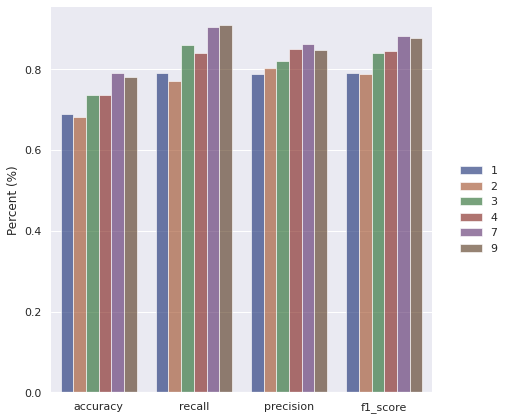

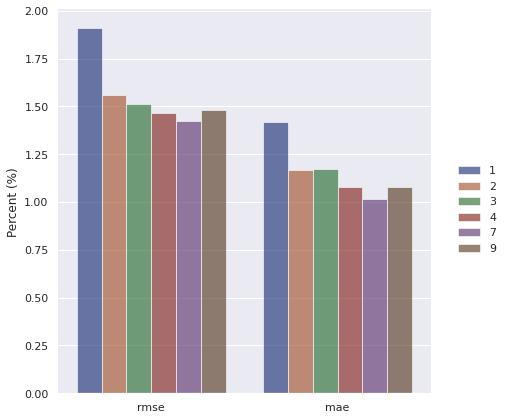

In [185]:

eval = evaluator()

df = pd.DataFrame(columns=['user','metric','score','neighbors'])
df2 = pd.DataFrame(columns=['user','metric','score','neighbors'])
for u in range(0,1):
  for i in [1,2,3,4,7,9]:
    model = cf_userbased(dataset = dataset,columns = columns,input_user = u,max_neighbors = i)
    grade_df= model.split_and_predict(test_split_size = 0.2) 
    a,b = eval.nei_metric_df(user=u,neigh=i,df=grade_df,threshold=3)
    df = df.append(a)
    df2 = df2.append(b)
# visualize scores
eval.visualize_bars(df=df,axe_x='metric',axe_y='score',hue='neighbors')
eval.visualize_bars(df=df2,axe_x='metric',axe_y='score',hue='neighbors')


# **`evaluator.py`**

In [187]:
import seaborn as sns
sns.set_theme()
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

class evaluator:

  def calculate_metrics(self,df,threshold):

    y_true = df['y_true'].tolist()
    y_pred = df['y_pred'].tolist()

    # calculate rmse
    rmse = mean_squared_error(y_true,y_pred)**(1/2)

    # calculate mae
    mae = mean_absolute_error(y_true,y_pred)   
    # convert predictions to binary based on threshold

    pred = [1 if x >=threshold else 0 for x in y_pred]
    true = [1 if x >=threshold else 0 for x in y_true]
    # calculate accuracy
    acc_ = accuracy_score(true,pred)
    # calculate recall
    rec_ = recall_score(true, pred)
    # calculate precision
    prec_ =precision_score(true, pred)
    # calculate f1 score
    f1_ = f1_score(true, pred)

    return rmse,mae,acc_,rec_,prec_,f1_


  def nei_metric_df(self,user,neigh,df,threshold):
    # calculate matrics
    rmse,mae,acc_,rec_,prec_,f1_ = self.calculate_metrics(df,threshold)
    # create a dataframe with those metrics, scores and neighbors
    df = pd.DataFrame(columns=['user','metric','score','neighbors']) 
    # append accuracy
    df = df.append(pd.DataFrame(data=[[user,'accuracy',acc_,neigh]],columns=['user','metric','score','neighbors']))
    # append recall
    df = df.append(pd.DataFrame(data=[[user,'recall',rec_,neigh]],columns=['user','metric','score','neighbors']))
    # append precision
    df = df.append(pd.DataFrame(data=[[user,'precision',prec_,neigh]],columns=['user','metric','score','neighbors']))
    # append f1_score
    df = df.append(pd.DataFrame(data=[[user,'f1_score',f1_,neigh]],columns=['user','metric','score','neighbors']))
    df2 = pd.DataFrame(columns=['user','metric','score','neighbors']) 
    # append accuracy
    df2 = df2.append(pd.DataFrame(data=[[user,'rmse',rmse,neigh]],columns=['user','metric','score','neighbors']))
    # append recall
    df2 = df2.append(pd.DataFrame(data=[[user,'mae',mae,neigh]],columns=['user','metric','score','neighbors']))
    
    return df,df2
    
  def user_metric_df(self,user,df,threshold):
    # calculate matrics
    rmse,mae,acc_,rec_,prec_,f1_ = self.calculate_metrics(df,threshold)
    # create a dataframe with those metrics and scores
    df = pd.DataFrame(columns=['user','metric','score']) 
    # append accuracy
    df = df.append(pd.DataFrame(data=[[user,'accuracy',acc_]],columns=['user','metric','score']))
    # append recall
    df = df.append(pd.DataFrame(data=[[user,'recall',rec_]],columns=['user','metric','score']))
    # append precision
    df = df.append(pd.DataFrame(data=[[user,'precision',prec_]],columns=['user','metric','score']))
    # append f1_score
    df = df.append(pd.DataFrame(data=[[user,'f1_score',f1_]],columns=['user','metric','score']))

    df2 = pd.DataFrame(columns=['user','metric','score']) 
    # append accuracy
    df2 = df2.append(pd.DataFrame(data=[[user,'rmse',rmse]],columns=['user','metric','score']))
    # append recall
    df2 = df2.append(pd.DataFrame(data=[[user,'mae',mae]],columns=['user','metric','score']))
    
    return df,df2

  def visualize_bars(self,df,axe_x,axe_y,hue):
    g = sns.catplot(
    data=df, kind="bar",
    x=axe_x, y=axe_y, hue=hue,
    ci="sd", palette="dark", alpha=.6, height=6,legend_out = True
    ) 
    g.despine(left=True)
    g.set_axis_labels("", "Percent (%)")
    g.legend.set_title("")
  def visualize_pie(self,df):

    plt.style.use('seaborn')
    fig, ax = plt.subplots(nrows=1, ncols=1)

    colors = ['#3cd070','#fc4f30', '#57595D']
    explode = (0.1, 0.1, 0)
    explode2 = (0.2, 0)
    sizes = []
    sizes.append(df['high_rated'].tolist()[0])
    sizes.append(df['low_rated'].tolist()[0])
    sizes.append(df['unrated'].tolist()[0])

    labels = ['high rated','low rated','unrated']
    #plt.tight_layout()
    ax.pie(sizes, startangle=90, colors=colors ,labels=labels, autopct='%1.f%%', explode=explode, shadow=True)
    ax.set_title('Coverage',fontsize=20, fontweight='bold')

    
  
    fig.suptitle('Evaluation of recommender', fontsize=25, y=1.07, fontweight='bold', x=0.37)


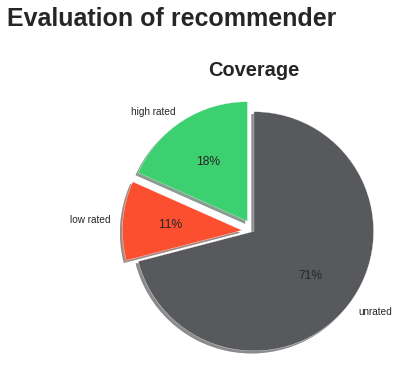

In [191]:
dffff = cf_userbased(dataset,columns,0,1).coverage()
evaluator().visualize_pie(dffff)

# **`cf_svd.py`**

In [194]:
import numpy as np
import pandas as pd
from scipy.linalg import sqrtm
from sklearn.model_selection import train_test_split

class cf_svd():

  def __init__(self,input_user,dataset,columns):
    self.input_user = input_user
    self.dataset = dataset
    self.columns = columns
    
  def svd(self,train, k):
    # get matrix values
    matrix = np.array(train)
    # mask nan or unavailable values
    mask = np.isnan(matrix)
    masked_arr = np.ma.masked_array(matrix, mask)
    # get means for every item
    item_means = np.mean(masked_arr, axis=0)    
    # replace nan with average
    matrix = masked_arr.filled(item_means)  
    x = np.tile(item_means, (matrix.shape[0],1))    
    # the above mentioned nan entries will be essentially zero now
    matrix = matrix - x    
    # U and V are user and item features
    U, s, V=np.linalg.svd(matrix, full_matrices=False)
    # take the k most significant features
    s=np.diag(s)   
    # get k most significant features
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]    
    s_root=sqrtm(s)    
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)    
    UsV = UsV + x    
    return UsV
  

  def recommend(self,itemsToPredict):
    matrix =  data_handler.create_matrix(dataset=self.dataset,columns=self.columns,fill_unrated_with=np.nan)
    pred_mat = pd.DataFrame(columns= matrix.columns.tolist(),data = self.svd(matrix, k=5))
    df = self.predict(pred_mat,itemsToPredict)
    c = df[self.columns[1]].tolist()
    for i in range(len(itemsToPredict)):
      if itemsToPredict[i] not in c:
        itemId = itemsToPredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.columns[1],'svd_pred']))

    return df

  def predict(self,matrix,itemToPredict):
    df = pd.DataFrame(columns=[self.columns[1],'svd_pred'])
    for i in range(len(itemToPredict)):
      pred_item = itemToPredict[i]
      if pred_item in matrix.columns:
        y_pred = matrix[pred_item][self.input_user]
        if np.isnan(y_pred) == False:
          df = df.append(pd.DataFrame(data=[[int(pred_item),y_pred]],columns=[self.columns[1],'svd_pred']))
    
    return df    

  def split_and_predict(self):
    # get all ratings of user input
    input_data = self.dataset.loc[self.dataset[self.columns[0]] == self.input_user]
    # split ratings to train and test
    train_X, test_X, train_y, test_y = train_test_split(input_data, input_data['rating'].tolist(), test_size=0.2, random_state=0)
    # copy dataset
    tmp_dataset = self.dataset.copy()
    # remove test data
    tmp_dataset = tmp_dataset.drop( index = test_X.index.tolist())
    # reset test index
    test_X = test_X.reset_index()
    # create user-item matrix with train data 
    matrix =  data_handler.create_matrix(dataset=tmp_dataset,columns=self.columns,fill_unrated_with=np.nan)
    # user index
    u_index = matrix.index.tolist()
    # item index
    i_index = matrix.columns.tolist()
    # predictions for test set
    pred_mat = pd.DataFrame(columns=i_index,data = self.svd(matrix, k=105))

    df = pd.DataFrame(columns=['clothId','y_pred','y_true'])
    for i in range(len(test_X)):
      item_X = test_X.iloc[i][self.columns[1]]#.tolist()
      if item_X in pred_mat.columns:
        y_true =  test_X.iloc[i][self.columns[2]].tolist()
        y_pred = pred_mat[item_X][self.input_user]
        df = df.append(pd.DataFrame(data=[[int(item_X),y_pred,y_true]],columns=['clothId','y_pred','y_true']))
    return df

  def hyb_eval(self,train,test):
    # create matrix without test data
    matrix = data_handler.create_matrix(train,self.columns,fill_unrated_with=np.nan)
    itemsToPredict = test[self.columns[1]].tolist()
    pred_mat = pd.DataFrame(columns= matrix.columns.tolist(),data = self.svd(matrix, k=105))
    df = self.predict(pred_mat,itemsToPredict)
    c = df[self.columns[1]].tolist()
    for i in range(len(itemsToPredict)):
      if itemsToPredict[i] not in c:
        itemId = itemsToPredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.columns[1],'svd_pred']))

    return df  
  def coverage(self):
    # get all id items
    all_items = [i for i in range(4325)] #self.dataset[self.columns[1]].unique()
    # get rated user items
    rated_items = self.dataset.loc[ self.dataset[self.columns[0]] == self.input_user][self.columns[1]].tolist()
    # get unrated
    unrated_items = list ( set(all_items)  - set(rated_items) )
    # recommend
    df  = self.recommend(unrated_items)
    low_rated = len(df.loc[df['svd_pred'] < 3])
    high_rated = len(df.loc[df['svd_pred'] >= 3])
    unrated = len(unrated_items)
  
    
    cov_df = pd.DataFrame()
    cov_df['high_rated'] = [high_rated]
    cov_df['low_rated'] = [low_rated]
    cov_df['unrated'] = [unrated]
    cov_df['coverage'] = [round((high_rated+low_rated) / unrated , 2)]
    
    return cov_df

In [ ]:
cf_svd(0,dataset,columns).split_and_predict()

# **`svd_main.py`**

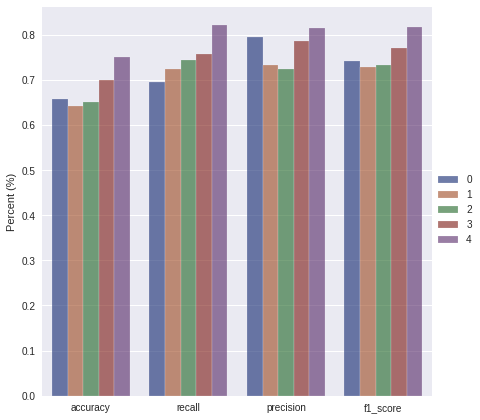

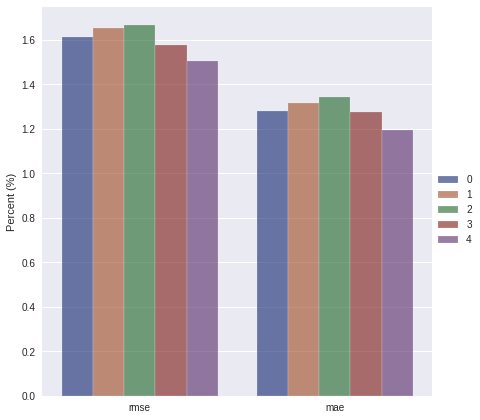

In [195]:

eval = evaluator()
df = pd.DataFrame(columns=['user','metric','score'])
df2 = pd.DataFrame(columns=['user','metric','score'])
for u in range(5):
  model = cf_svd(input_user = u,dataset = dataset,columns = columns)
  grade_df = model.split_and_predict()
  a,b = eval.user_metric_df(user=u,df=grade_df,threshold=3)
  df = df.append(a)
  df2 = df2.append(b)

eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='user')

eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='user')

In [ ]:
grade_df

# **`cf_deep_model.py`**

In [196]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda
from keras.layers import LeakyReLU

class cf_deep_model():

  def EmbeddingLayer(self,x,total_rows,total_cols):
    x = Embedding(total_rows, total_cols, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
    x = Reshape((total_cols,))(x)
    return x

  def __init__(self,t_users,t_items,factors,min_rating,max_rating):
    
    self.t_users = t_users
    self.t_items = t_items
    self.factors = factors

    user = Input(shape=(1,))
    u = self.EmbeddingLayer(user,t_users, factors)
    
    item = Input(shape=(1,))
    i = self.EmbeddingLayer(item,t_items, factors)
    
    x = Concatenate()([u, i])
    #x = Dropout(0.1)(x)
    
    x = Dense(512, kernel_initializer='lecun_normal')(x)
    x = Activation('tanh')(x)
    x = Dropout(0.35)(x)

    x = Dense(512, kernel_initializer='lecun_normal')(x)
    x = Activation('tanh')(x)
    x = Dropout(0.35)(x)

    x = Dense(512, kernel_initializer='lecun_normal')(x)
    x = Activation('tanh')(x)
    x = Dropout(0.15)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)
    #x = LeakyReLU(alpha=0.1)(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)    
    self.model = Model(inputs=[user, item], outputs=x)
    #opt = Adam(lr=0.01)
 
    #self.model.compile(loss='mean_absolute_error', optimizer=opt)


# **`cf_deep.py`**

In [197]:
import keras
import tensorflow as tf 
from keras.callbacks import ModelCheckpoint

class cf_deep():

  def __init__(self,preprocess_pack,handler,cols,user_input):
   
    self.user_input = user_input
    self.handler = handler
    self.cols = cols
    df , t_users, t_items , minmax , enc = preprocess_pack
    self.df = df
    self.t_users = t_users
    self.t_items = t_items
    self.min_rating , self.max_rating = minmax
    self.enc = enc
    self.model = cf_deep_model(t_users,t_items,5,self.min_rating,self.max_rating).model

  def convertInput(self,train,test):
    TRAIN = train.values
    TEST = test.values
    X_train = [TRAIN[:, 0], TRAIN[:, 1]]
    y_train = TRAIN[:, 2]
    X_test = [TEST[:, 0], TEST[:, 1]]
    y_test = TEST[:, 2]
    return X_train,y_train,X_test,y_test

  def recommend(self,itemsTopredict):
    
    train,test = self.handler.rec_split(self.df)
   
    X_train,y_train,X_test,y_test = self.convertInput(train,test)
    
    self.train(X_train,y_train,X_test,y_test)
    
    self.load_best_model()
    
    canTransform = self.enc.classes_
    itemstp = []
    for i in range(len(itemsTopredict)):
      if itemsTopredict[i] in canTransform:
        itemstp.append(itemsTopredict[i])
    predItems = self.enc.transform(itemstp)
    a = [self.user_input for i in range(len(predItems))]
    X_pred = [np.array(a), np.array(predItems)]
    y_pred = np.array(self.model.predict(X_pred))
    df = pd.DataFrame(columns=[self.cols[1],'dl_pred'])
    df[self.cols[1]] = self.enc.inverse_transform(predItems)
    df['dl_pred'] = y_pred
    c = df[self.cols[1]].tolist()
    for i in range(len(itemsTopredict)):
      if itemsTopredict[i] not in c:
        itemId = itemsTopredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.cols[1],'dl_pred']))

    return df

  def split_and_predict(self):
    # split data to train and test set
    train,test = self.handler.split(self.df,self.user_input,0.1)
    X_train,y_train,X_test,y_test = self.convertInput(train,test)
 
    self.train(X_train,y_train,X_test,y_test)
    self.load_best_model()
    y_pred = np.array(self.model.predict(X_test))
    df = pd.DataFrame(columns=[self.cols[1],'y_true','y_pred'])
    df[self.cols[1]] = test[self.cols[1]].tolist()
    df['y_true'] = y_test
    df['y_pred'] = y_pred

    return df
    
  def train(self,X_train,y_train,X_test,y_test):
    filepath ="/content/drive/My Drive/models/weights_dl.hdf5"
    # Keep only a single checkpoint, the best over test accuracy.
    checkpoint = ModelCheckpoint(filepath,
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode='min')   

    self.model.compile(optimizer= 'adam', loss=tf.keras.losses.MeanSquaredError())

    train = self.model.fit(x=X_train, y=np.array(y_train),
            batch_size=256,
            epochs=10,
            verbose=1,
            validation_data=(X_test, np.array(y_test)),
            shuffle=True,
            callbacks=[checkpoint])
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(train.history) 
    # save to csv: 
    hist_csv_file = '/content/drive/My Drive/models/history_dl.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f) 

  def load_best_model(self):
    filepath ="/content/drive/My Drive/models/weights_dl.hdf5"
    self.model = cf_deep_model(self.t_users,self.t_items,5,self.min_rating,self.max_rating).model
    self.model.load_weights(filepath)

  def hyb_eval(self,train,test):

    itemsTopredict = test[self.cols[1]].tolist()

    #print(test[self.cols[1]])
    u_test = test.copy()
    u_test[self.cols[1]] = self.enc.transform(test[self.cols[1]].tolist() )
    #print(test[self.cols[1]])
    u_train = train.copy()
    u_train[self.cols[1]] = self.enc.transform(train[self.cols[1]].tolist() )

    X_train,y_train,X_test,y_test = self.convertInput(u_train,u_test)


    X_train[0] = X_train[0].astype('float64')
    X_train[1] = X_train[1].astype('float64')
    X_test[0] = X_test[0].astype('float64')
    X_test[1] = X_test[1].astype('float64')
    y_train = np.array(y_train).astype('float64')
    y_test = np.array(y_test).astype('float64')

    self.train(X_train,y_train,X_test,y_test)

    self.load_best_model()
    
    canTransform = self.enc.classes_
    itemstp = []
    for i in range(len(itemsTopredict)):
      if itemsTopredict[i] in canTransform:
        itemstp.append(itemsTopredict[i])
    predItems = self.enc.transform(itemstp)
    a = [self.user_input for i in range(len(predItems))]
    X_pred = [np.array(a), np.array(predItems)]
    y_pred = np.array(self.model.predict(X_pred))
    df = pd.DataFrame(columns=[self.cols[1],'dl_pred'])
    df[self.cols[1]] = self.enc.inverse_transform(predItems)
    df['dl_pred'] = y_pred
    c = df[self.cols[1]].tolist()
    for i in range(len(itemsTopredict)):
      if itemsTopredict[i] not in c:
        itemId = itemsTopredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.cols[1],'dl_pred']))
    return df

  def coverage(self):
    train,test = self.handler.split(self.df,self.user_input,0.1)
     # get all id items
    all_items = self.df[self.cols[1]].unique()
    all_dataset_items = [i for i in range(4325)]
    # get rated user items
    rated_items = self.df.loc[ self.df[self.cols[0]] == self.user_input][self.cols[1]].tolist()
    unrated_dataset_items = list ( set(all_dataset_items)  - set(rated_items) )
    
    # get unrated
    unrated_items = list ( set(all_items)  - set(rated_items) )
    X_train,y_train,X_test,y_test = self.convertInput(train,test)
    
    self.train(X_train,y_train,X_test,y_test)
    
    self.load_best_model()

    a = [self.user_input for i in range(len(unrated_items))]
    X_pred = [np.array(a), np.array(unrated_items)]
    y_pred = np.array(self.model.predict(X_pred))
    df = pd.DataFrame(columns=[self.cols[1],'dl_pred'])
    df[self.cols[1]] = unrated_items
    df['dl_pred'] = y_pred
    low_rated = len(df.loc[df['dl_pred'] < 3])
    high_rated = len(df.loc[df['dl_pred'] >= 3])
    unrated = len(unrated_dataset_items)
    cov_df = pd.DataFrame()
    cov_df['high_rated'] = [high_rated]
    cov_df['low_rated'] = [low_rated]
    cov_df['unrated'] = [unrated]
    cov_df['coverage'] = [round((high_rated+low_rated) / unrated , 2)]
    return cov_df
    '''
    # recommend
    df  = self.recommend(unrated_items)
    low_rated = len(df.loc[df['ub_pred'] < 3])
    high_rated = len(df.loc[df['ub_pred'] >= 3])
    unrated = len(unrated_items)
  
    
    cov_df = pd.DataFrame()
    cov_df['high_rated'] = [high_rated]
    cov_df['low_rated'] = [low_rated]
    cov_df['unrated'] = [unrated]
    cov_df['coverage'] = [round((high_rated+low_rated) / unrated , 2)]
    
    '''

In [ ]:
handler = data_handler(path,columns)

preprocess_pack = handler.deep_preprocessing(dataset)

cf_deep(preprocess_pack,handler,columns,0).coverage()

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


83/84 [============================>.] - ETA: 0s - loss: 6.7738
Epoch 00001: val_loss improved from inf to 2.53309, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 36ms/step - loss: 6.7552 - val_loss: 2.5331
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.1939
Epoch 00002: val_loss improved from 2.53309 to 2.45105, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 29ms/step - loss: 3.1936 - val_loss: 2.4511
Epoch 3/10
83/84 [============================>.] - ETA: 0s - loss: 2.8333
Epoch 00003: val_loss did not improve from 2.45105
84/84 [==============================] - 2s 29ms/step - loss: 2.8306 - val_loss: 2.5236
Epoch 4/10
83/84 [============================>.] - ETA: 0s - loss: 2.5186
Epoch 00004: val_loss did not improve from 2.45105
84/84 [==============================] - 2s 29ms/step - loss: 2.5222 - val_loss: 2.7334
Epoch 5/10
83/84 [=====

,high_rated,low_rated,unrated,coverage
0,1327,777,2162,0.97


# **`cf_deep_main.py`**

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


83/84 [============================>.] - ETA: 0s - loss: 6.9467
Epoch 00001: val_loss improved from inf to 4.11858, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 36ms/step - loss: 6.9251 - val_loss: 4.1186
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.4286
Epoch 00002: val_loss improved from 4.11858 to 2.59808, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 27ms/step - loss: 3.4284 - val_loss: 2.5981
Epoch 3/10
83/84 [============================>.] - ETA: 0s - loss: 3.2031
Epoch 00003: val_loss improved from 2.59808 to 2.37448, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 28ms/step - loss: 3.1991 - val_loss: 2.3745
Epoch 4/10
83/84 [============================>.] - ETA: 0s - loss: 2.7763
Epoch 00004: val_loss did not improve from 2.37448
84/84 [==============================] - 2s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


83/84 [============================>.] - ETA: 0s - loss: 6.9442
Epoch 00001: val_loss improved from inf to 2.56296, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 32ms/step - loss: 6.9224 - val_loss: 2.5630
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.2211
Epoch 00002: val_loss did not improve from 2.56296
84/84 [==============================] - 2s 27ms/step - loss: 3.2193 - val_loss: 2.6550
Epoch 3/10
83/84 [============================>.] - ETA: 0s - loss: 3.0000
Epoch 00003: val_loss improved from 2.56296 to 2.29439, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 28ms/step - loss: 3.0017 - val_loss: 2.2944
Epoch 4/10
83/84 [============================>.] - ETA: 0s - loss: 2.6698
Epoch 00004: val_loss improved from 2.29439 to 2.08860, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


83/84 [============================>.] - ETA: 0s - loss: 6.9254
Epoch 00001: val_loss improved from inf to 2.52564, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 32ms/step - loss: 6.9025 - val_loss: 2.5256
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.1464
Epoch 00002: val_loss did not improve from 2.52564
84/84 [==============================] - 2s 28ms/step - loss: 3.1483 - val_loss: 2.6186
Epoch 3/10
83/84 [============================>.] - ETA: 0s - loss: 2.8035
Epoch 00003: val_loss did not improve from 2.52564
84/84 [==============================] - 2s 27ms/step - loss: 2.8024 - val_loss: 2.5677
Epoch 4/10
82/84 [============================>.] - ETA: 0s - loss: 2.4767
Epoch 00004: val_loss did not improve from 2.52564
84/84 [==============================] - 2s 28ms/step - loss: 2.4748 - val_loss: 2.9536
Epoch 5/10
83/84 [============================>.] - ETA: 0s - loss: 2.2877
Epoch 00005: val

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


83/84 [============================>.] - ETA: 0s - loss: 7.1607
Epoch 00001: val_loss improved from inf to 2.62218, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 32ms/step - loss: 7.1379 - val_loss: 2.6222
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.3205
Epoch 00002: val_loss did not improve from 2.62218
84/84 [==============================] - 2s 27ms/step - loss: 3.3207 - val_loss: 2.7355
Epoch 3/10
83/84 [============================>.] - ETA: 0s - loss: 3.1135
Epoch 00003: val_loss improved from 2.62218 to 2.33279, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 27ms/step - loss: 3.1093 - val_loss: 2.3328
Epoch 4/10
83/84 [============================>.] - ETA: 0s - loss: 2.7153
Epoch 00004: val_loss did not improve from 2.33279
84/84 [==============================] - 2s 27ms/step - loss: 2.7133 - val_loss: 2.4671
Epoch 5/10
83/84 [=====

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


83/84 [============================>.] - ETA: 0s - loss: 5.0824
Epoch 00001: val_loss improved from inf to 3.00889, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 32ms/step - loss: 5.0689 - val_loss: 3.0089
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.1583
Epoch 00002: val_loss improved from 3.00889 to 2.85615, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 27ms/step - loss: 3.1586 - val_loss: 2.8562
Epoch 3/10
83/84 [============================>.] - ETA: 0s - loss: 2.7607
Epoch 00003: val_loss improved from 2.85615 to 2.64632, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 27ms/step - loss: 2.7595 - val_loss: 2.6463
Epoch 4/10
82/84 [============================>.] - ETA: 0s - loss: 2.3609
Epoch 00004: val_loss did not improve from 2.64632
84/84 [==============================] - 2s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


82/84 [============================>.] - ETA: 0s - loss: 6.3574
Epoch 00001: val_loss improved from inf to 2.60172, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 32ms/step - loss: 6.3058 - val_loss: 2.6017
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.2067
Epoch 00002: val_loss improved from 2.60172 to 2.42807, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 27ms/step - loss: 3.2029 - val_loss: 2.4281
Epoch 3/10
83/84 [============================>.] - ETA: 0s - loss: 3.0156
Epoch 00003: val_loss improved from 2.42807 to 2.23637, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 27ms/step - loss: 3.0164 - val_loss: 2.2364
Epoch 4/10
83/84 [============================>.] - ETA: 0s - loss: 2.6643
Epoch 00004: val_loss improved from 2.23637 to 2.14841, saving model to /content/drive/My Driv

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


83/84 [============================>.] - ETA: 0s - loss: 7.1859
Epoch 00001: val_loss improved from inf to 2.85445, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 34ms/step - loss: 7.1666 - val_loss: 2.8544
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.3980
Epoch 00002: val_loss improved from 2.85445 to 2.62901, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 28ms/step - loss: 3.3986 - val_loss: 2.6290
Epoch 3/10
82/84 [============================>.] - ETA: 0s - loss: 3.1177
Epoch 00003: val_loss did not improve from 2.62901
84/84 [==============================] - 2s 27ms/step - loss: 3.1119 - val_loss: 2.9234
Epoch 4/10
83/84 [============================>.] - ETA: 0s - loss: 2.6786
Epoch 00004: val_loss did not improve from 2.62901
84/84 [==============================] - 2s 27ms/step - loss: 2.6767 - val_loss: 2.8425
Epoch 5/10
83/84 [=====

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


83/84 [============================>.] - ETA: 0s - loss: 5.9631
Epoch 00001: val_loss improved from inf to 2.68627, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 32ms/step - loss: 5.9511 - val_loss: 2.6863
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.2710
Epoch 00002: val_loss did not improve from 2.68627
84/84 [==============================] - 2s 27ms/step - loss: 3.2686 - val_loss: 2.9327
Epoch 3/10
83/84 [============================>.] - ETA: 0s - loss: 2.9645
Epoch 00003: val_loss improved from 2.68627 to 2.52338, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 28ms/step - loss: 2.9638 - val_loss: 2.5234
Epoch 4/10
83/84 [============================>.] - ETA: 0s - loss: 2.5264
Epoch 00004: val_loss did not improve from 2.52338
84/84 [==============================] - 2s 27ms/step - loss: 2.5249 - val_loss: 2.5775
Epoch 5/10
83/84 [=====

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


83/84 [============================>.] - ETA: 0s - loss: 6.2275
Epoch 00001: val_loss improved from inf to 2.48656, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 32ms/step - loss: 6.2100 - val_loss: 2.4866
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.2738
Epoch 00002: val_loss improved from 2.48656 to 2.45043, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 28ms/step - loss: 3.2764 - val_loss: 2.4504
Epoch 3/10
83/84 [============================>.] - ETA: 0s - loss: 3.0340
Epoch 00003: val_loss improved from 2.45043 to 2.34574, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 28ms/step - loss: 3.0352 - val_loss: 2.3457
Epoch 4/10
83/84 [============================>.] - ETA: 0s - loss: 2.6275
Epoch 00004: val_loss improved from 2.34574 to 2.29363, saving model to /content/drive/My Driv

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


83/84 [============================>.] - ETA: 0s - loss: 7.3527
Epoch 00001: val_loss improved from inf to 2.59509, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 34ms/step - loss: 7.3298 - val_loss: 2.5951
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.1967
Epoch 00002: val_loss did not improve from 2.59509
84/84 [==============================] - 2s 27ms/step - loss: 3.1951 - val_loss: 2.6137
Epoch 3/10
83/84 [============================>.] - ETA: 0s - loss: 2.9795
Epoch 00003: val_loss improved from 2.59509 to 2.36416, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 28ms/step - loss: 2.9776 - val_loss: 2.3642
Epoch 4/10
83/84 [============================>.] - ETA: 0s - loss: 2.6247
Epoch 00004: val_loss improved from 2.36416 to 2.14643, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s

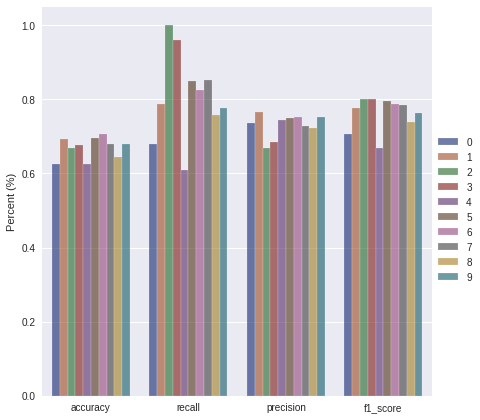

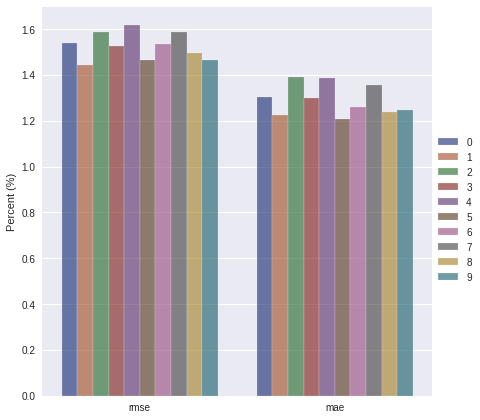

In [198]:
handler = data_handler(path,columns)

preprocess_pack = handler.deep_preprocessing(dataset)

eval = evaluator()

df = pd.DataFrame(columns=['user','metric','score'])
df2 = pd.DataFrame(columns=['user','metric','score'])

for u in range(10):
  dl = cf_deep(preprocess_pack,handler,columns,u)
  grade_df = dl.split_and_predict()
  a,b = eval.user_metric_df(user=u,df=grade_df,threshold=3)
  df = df.append(a)
  df2 = df2.append(b)
eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='user')
eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='user')





In [ ]:
feautures = pd.read_pickle('/content/drive/My Drive/clothes_attr.pkl')
feautures.index.tolist()

# **`cb_rf.py`**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import pandas as pd


class cb_rf():
  
  def __init__(self,input_user):
    self.input_user = input_user
    self.df = pd.read_pickle('/content/drive/My Drive/multi-user5.pkl')
    self.df = self.df.loc[self.df['UserId'] == input_user]
    self.df = self.df.drop_duplicates(subset='ImageSource',keep='first')
    self.prodNo = self.df['ProductNo'].tolist()
    self.ratings = self.df['gradeUser'].tolist()
    self.all_clothes = pd.read_pickle('/content/drive/My Drive/clothes_attr.pkl')
    self.rated_clothes = self.all_clothes.copy()
    self.rated_clothes['ratings'] = self.ratings
    

    z = []
    for i in range(4325):
      z.append([])

    for i in range(10):
      if i != self.input_user:
        rating_data = pd.read_pickle('/content/drive/My Drive/multi-user5.pkl')
        u_data = rating_data.loc[rating_data['UserId'] == i]
        u_data = u_data.drop_duplicates(subset='ImageSource',keep='first')
        for j in range(len(u_data)):
          if u_data.iloc[j]['gradeUser']!=2.5:
            z[j].append(u_data.iloc[j]['gradeUser'])
    for i in range(len(z)):
      if len(z[i])>0:
        z[i] = sum(z[i]) / len(z[i])
      else:
        z[i] = -1
    self.rated_clothes['avg_rating'] = z
    self.unrated_clothes = self.rated_clothes.copy()
    self.unrated_clothes = self.unrated_clothes.loc[self.unrated_clothes['ratings'] ==2.5]
    self.rated_clothes = self.rated_clothes.loc[self.rated_clothes['ratings'] != 2.5]
    self.ratings = self.rated_clothes['ratings'].tolist()
    self.rated_clothes = self.rated_clothes.drop(columns='ratings')
    self.unrated_clothes = self.unrated_clothes.drop(columns='ratings')

  def recommend(self,itemsTopredict):
    # init regressor rf
    regr = RandomForestRegressor(n_estimators=100,criterion='mse', random_state=1)
    # train 
    regr.fit(self.rated_clothes, self.ratings)
    # predict
    pred_X = self.unrated_clothes.loc[itemsTopredict]
    y_pred = regr.predict(pred_X)
    # result dataframe
    df = pd.DataFrame()
    df['clothId'] = pred_X.index.tolist()
    df['rf_pred'] = y_pred
   
    return df

  def split_and_predict(self):
    # init regressor rf
    regr = RandomForestRegressor(n_estimators=80,max_depth=20,criterion='mse', random_state=1)
    # split data
    train_X, test_X, train_y, test_y = train_test_split(self.rated_clothes, self.ratings, test_size=0.1, random_state=1)
    # train 
    regr.fit(train_X,train_y)
    # predict
    y_pred = regr.predict(test_X)
   
    # result dataframe
    df = pd.DataFrame(columns=['clothId','y_pred','y_true'])
    df['clothId'] = test_X.index.tolist()
    df['y_true'] = test_y
    df['y_pred'] = y_pred

    return df
  def hyb_eval(self,train,test):
    # init regressor rf
    regr = RandomForestRegressor(n_estimators=100,criterion='mse', random_state=1)
    # train 
    d_train = self.rated_clothes.copy()
    d_train['rating'] = self.ratings.copy()
    train_X = d_train.loc[train['clothId'].tolist()]
    train_y = train_X['rating'].tolist()
    train_X = train_X.drop(columns='rating')
    d_test = self.rated_clothes.copy()
    d_test['rating'] = self.ratings
    test_X = d_test.loc[test['clothId'].tolist()]
    test_y = test_X['rating'].tolist()
    test_X = test_X.drop(columns='rating')
    # train 
    regr.fit(train_X,train_y)
    # predict
    y_pred = regr.predict(test_X)
    
    # result dataframe
    df = pd.DataFrame(columns=['clothId','rf_pred'])
    df['clothId'] = test_X.index.tolist()
    #df['y_true'] = test_y
    df['rf_pred'] = y_pred

    return df

  def coverage(self):
    # init regressor rf
    regr = RandomForestRegressor(n_estimators=100,criterion='mse', random_state=1)
    # train 
    regr.fit(self.rated_clothes, self.ratings)
    # predict
    y_pred = regr.predict(self.unrated_clothes)
    # save pred
    df = pd.DataFrame(columns=['clothId','rf_pred'])
    df['clothId'] = self.unrated_clothes.index.tolist()
    df['rf_pred'] = y_pred
    low_rated = len(df.loc[df['rf_pred'] < 3])
    high_rated = len(df.loc[df['rf_pred'] >= 3])
    unrated = 1
    cov_df = pd.DataFrame()
    cov_df['high_rated'] = [high_rated]
    cov_df['low_rated'] = [low_rated]
    cov_df['unrated'] = [unrated]
    cov_df['coverage'] = [round((high_rated+low_rated) / unrated , 2)]
    return cov_df

In [ ]:
cb_rf(0).coverage()

,high_rated,low_rated,unrated,coverage
0,1316,846,1,2162.0


# **`cb_rf_main.py`**

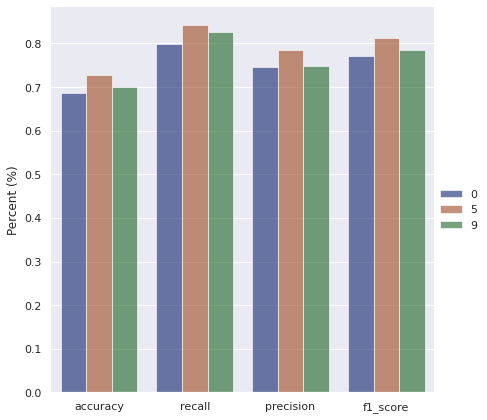

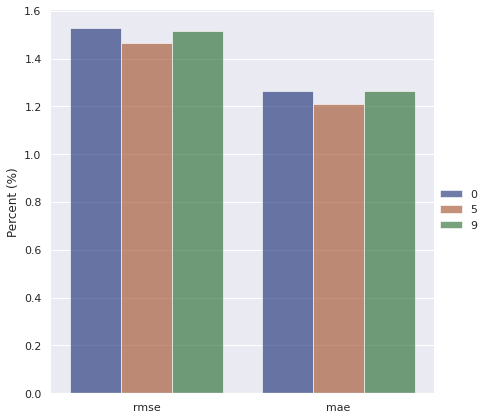

In [ ]:
eval = evaluator()
df = pd.DataFrame(columns=['user','metric','score'])
df2 = pd.DataFrame(columns=['user','metric','score'])
for u in [0,5,9]:
  model = cb_rf(input_user = u)
  grade_df = model.split_and_predict()
  a,b = eval.user_metric_df(user=u,df=grade_df,threshold=3)
  df = df.append(a)
  df2 = df2.append(b)

eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='user')

eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='user')


# **`cb_nn.py`**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

class cb_nn():
  def __init__(self,input_user):
    self.input_user = input_user
    self.input_user = input_user
    self.df = pd.read_pickle('/content/drive/My Drive/multi-user5.pkl')
    self.df = self.df.loc[self.df['UserId'] == input_user]
    self.df = self.df.drop_duplicates(subset='ImageSource',keep='first')
    self.prodNo = self.df['ProductNo'].tolist()
    self.ratings = self.df['gradeUser'].tolist()
    self.all_clothes = pd.read_pickle('/content/drive/My Drive/clothes_attr.pkl')
    self.rated_clothes = self.all_clothes.copy()
    self.rated_clothes['ratings'] = self.ratings

    z = []
    for i in range(4325):
      z.append([])

    for i in range(10):
      if i != self.input_user:
        rating_data = pd.read_pickle('/content/drive/My Drive/multi-user5.pkl')
        u_data = rating_data.loc[rating_data['UserId'] == i]
        u_data = u_data.drop_duplicates(subset='ImageSource',keep='first')
        for j in range(len(u_data)):
          if u_data.iloc[j]['gradeUser']!=2.5:
            z[j].append(u_data.iloc[j]['gradeUser'])
    for i in range(len(z)):
      if len(z[i])>0:
        z[i] = sum(z[i]) / len(z[i])
      else:
        z[i] = -1
    self.rated_clothes['avg_rating'] = z
    self.unrated_clothes = self.rated_clothes.copy()
    self.unrated_clothes = self.unrated_clothes.loc[self.unrated_clothes['ratings'] ==2.5]
    self.rated_clothes = self.rated_clothes.loc[self.rated_clothes['ratings'] != 2.5]
    self.ratings = self.rated_clothes['ratings'].tolist()
    self.rated_clothes = self.rated_clothes.drop(columns='ratings')
    self.unrated_clothes = self.unrated_clothes.drop(columns='ratings')

  def split_and_predict(self):
    # init regressor rf
    model = self.model_init()
    # split data
    train_X, test_X, train_y, test_y = train_test_split(self.rated_clothes, self.ratings, test_size=0.1, random_state=1)
    # train 
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min',restore_best_weights=True)
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

    history = model.fit(np.array(train_X.values), np.array(train_y), epochs=10,callbacks=[earlyStopping,reduce_lr_loss], validation_split=0.1)
    # predict
    y_pred = model.predict(test_X)
    
    # result dataframe
    df = pd.DataFrame(columns=['clothId','y_pred','y_true'])
    df['clothId'] = test_X.index.tolist()
    df['y_true'] = test_y
    df['y_pred'] = y_pred

    return df
     
  def model_init(self):
    model = Sequential()
    model.add(Dense(128, input_shape=(412, ), activation='tanh', name='dense_1'))
    model.add(Dropout(0.01))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(128, activation='tanh', name='dense_2'))
    model.add(Dropout(0.01))
    model.add(Dense(128, activation='tanh', name='dense_3'))
    model.add(Dense(1, activation='linear', name='dense_output'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

  def convert_index(self,old):
    id_db = pd.read_pickle('/content/drive/My Drive/id_db.pkl')
    new_list = id_db['id'].tolist()
    old_list = id_db['db_id'].tolist()
    new = []
    for j in range(len(old)):
      for i in range(len(id_db)):
        if old[j] in old_list[i]:
          new.append(new_list[i])
    return new
    
  def hyb_eval(self,train,test):
    # init regressor rf
    model = self.model_init()
    d_train = self.rated_clothes.copy()
    d_train['rating'] = self.ratings.copy()
    train_X = d_train.loc[train['clothId'].tolist()]
  
    train_y = train_X['rating'].tolist()
  
    train_X = train_X.drop(columns='rating')
    d_test = self.rated_clothes.copy()
    d_test['rating'] = self.ratings
    test_X = d_test.loc[test['clothId'].tolist()]
   
    test_y = test_X['rating'].tolist()
    
    test_X = test_X.drop(columns='rating')
    # train 
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min',restore_best_weights=True)
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

    history = model.fit(np.array(train_X.values), np.array(train_y), epochs=10,callbacks=[earlyStopping,reduce_lr_loss], validation_split=0.05)
    # predict
    y_pred = model.predict(test_X)
    
    # result dataframe
    df = pd.DataFrame(columns=['clothId','nn_pred'])
    df['clothId'] = test_X.index.tolist()
    #df['y_true'] = test_y
    df['nn_pred'] = y_pred

    return df

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/multi-user5.pkl')
df = df.loc[df['UserId'] == input_user]
df = df.drop_duplicates(subset='ImageSource',keep='first')
df['index'] = [i for i in range(4325)]
df.loc[df['index'].isin(train['clothId'].tolist())]


In [ ]:
train

,userId,clothId,rating
0,0,1,5.0
1,0,3,3.0
2,0,4,4.5
3,0,8,4.5
4,0,9,3.5
...,...,...,...
21586,9,4308,0.5
21587,9,4310,3.5
21588,9,4313,0.5
21589,9,4314,0.5


# **`cb_nn_main.py`**

Epoch 1/10
105/105 [==============================] - 0s 4ms/step - loss: 4.4311 - mae: 1.8106 - val_loss: 4.5059 - val_mae: 1.8331
Epoch 2/10
105/105 [==============================] - 0s 3ms/step - loss: 4.3617 - mae: 1.8089 - val_loss: 4.5208 - val_mae: 1.8093
Epoch 3/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2942 - mae: 1.7922 - val_loss: 4.5367 - val_mae: 1.8198
Epoch 4/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2629 - mae: 1.7761 - val_loss: 4.5079 - val_mae: 1.8545
Epoch 5/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2197 - mae: 1.7673 - val_loss: 4.6408 - val_mae: 1.8355
Epoch 6/10
105/105 [==============================] - 0s 2ms/step - loss: 4.1899 - mae: 1.7569 - val_loss: 4.6305 - val_mae: 1.7772


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
105/105 [==============================] - 0s 4ms/step - loss: 4.3519 - mae: 1.7848 - val_loss: 4.5034 - val_mae: 1.8206
Epoch 2/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2700 - mae: 1.7727 - val_loss: 4.5115 - val_mae: 1.8236
Epoch 3/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2172 - mae: 1.7578 - val_loss: 4.5214 - val_mae: 1.8157
Epoch 4/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2026 - mae: 1.7487 - val_loss: 4.5283 - val_mae: 1.8361
Epoch 5/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1557 - mae: 1.7429 - val_loss: 4.5399 - val_mae: 1.8581
Epoch 6/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1431 - mae: 1.7276 - val_loss: 4.5993 - val_mae: 1.8850


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
105/105 [==============================] - 0s 4ms/step - loss: 4.4375 - mae: 1.8125 - val_loss: 4.7149 - val_mae: 1.9218
Epoch 2/10
105/105 [==============================] - 0s 2ms/step - loss: 4.3255 - mae: 1.7977 - val_loss: 4.7334 - val_mae: 1.8600
Epoch 3/10
105/105 [==============================] - 0s 2ms/step - loss: 4.2926 - mae: 1.7827 - val_loss: 4.7999 - val_mae: 1.9174
Epoch 4/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2452 - mae: 1.7703 - val_loss: 4.7679 - val_mae: 1.9000
Epoch 5/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2195 - mae: 1.7667 - val_loss: 4.7529 - val_mae: 1.8490
Epoch 6/10
105/105 [==============================] - 0s 2ms/step - loss: 4.1896 - mae: 1.7513 - val_loss: 4.7373 - val_mae: 1.8649


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
105/105 [==============================] - 0s 4ms/step - loss: 4.5103 - mae: 1.8306 - val_loss: 4.0419 - val_mae: 1.7280
Epoch 2/10
105/105 [==============================] - 0s 3ms/step - loss: 4.3456 - mae: 1.8004 - val_loss: 4.2200 - val_mae: 1.8064
Epoch 3/10
105/105 [==============================] - 0s 3ms/step - loss: 4.3131 - mae: 1.7916 - val_loss: 4.0508 - val_mae: 1.7362
Epoch 4/10
105/105 [==============================] - 0s 2ms/step - loss: 4.2709 - mae: 1.7894 - val_loss: 4.1932 - val_mae: 1.7160
Epoch 5/10
105/105 [==============================] - 0s 2ms/step - loss: 4.2210 - mae: 1.7659 - val_loss: 4.1572 - val_mae: 1.7617
Epoch 6/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2119 - mae: 1.7642 - val_loss: 4.4364 - val_mae: 1.8270


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
105/105 [==============================] - 0s 4ms/step - loss: 4.3484 - mae: 1.7916 - val_loss: 4.6954 - val_mae: 1.9346
Epoch 2/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2073 - mae: 1.7570 - val_loss: 4.7150 - val_mae: 1.9409
Epoch 3/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1527 - mae: 1.7454 - val_loss: 4.7983 - val_mae: 1.8774
Epoch 4/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1197 - mae: 1.7325 - val_loss: 4.7609 - val_mae: 1.8767
Epoch 5/10
105/105 [==============================] - 0s 2ms/step - loss: 4.0710 - mae: 1.7154 - val_loss: 4.8392 - val_mae: 1.8427
Epoch 6/10
105/105 [==============================] - 0s 3ms/step - loss: 4.0506 - mae: 1.7154 - val_loss: 4.9832 - val_mae: 1.8133


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
105/105 [==============================] - 0s 4ms/step - loss: 4.4752 - mae: 1.8138 - val_loss: 4.4531 - val_mae: 1.8289
Epoch 2/10
105/105 [==============================] - 0s 3ms/step - loss: 4.3549 - mae: 1.8104 - val_loss: 4.5570 - val_mae: 1.8467
Epoch 3/10
105/105 [==============================] - 0s 3ms/step - loss: 4.3185 - mae: 1.7898 - val_loss: 4.4461 - val_mae: 1.8195
Epoch 4/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2711 - mae: 1.7824 - val_loss: 4.5411 - val_mae: 1.8219
Epoch 5/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2275 - mae: 1.7652 - val_loss: 4.5781 - val_mae: 1.8759
Epoch 6/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1945 - mae: 1.7632 - val_loss: 4.5881 - val_mae: 1.8313
Epoch 7/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1979 - mae: 1.7565 - val_loss: 4.5365 - val_mae: 1.7755
Epoch 8/10
105/105 [==============================] - 0s 3ms/step - loss: 4.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
105/105 [==============================] - 0s 4ms/step - loss: 4.3266 - mae: 1.7796 - val_loss: 4.7147 - val_mae: 1.8401
Epoch 2/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2374 - mae: 1.7641 - val_loss: 4.7799 - val_mae: 1.8576
Epoch 3/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1818 - mae: 1.7575 - val_loss: 4.7696 - val_mae: 1.8268
Epoch 4/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1453 - mae: 1.7374 - val_loss: 4.8111 - val_mae: 1.8284
Epoch 5/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1024 - mae: 1.7214 - val_loss: 4.7890 - val_mae: 1.8603
Epoch 6/10
105/105 [==============================] - 0s 3ms/step - loss: 4.0677 - mae: 1.7138 - val_loss: 4.8102 - val_mae: 1.8354


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
105/105 [==============================] - 0s 4ms/step - loss: 4.3338 - mae: 1.7791 - val_loss: 4.6401 - val_mae: 1.7923
Epoch 2/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2205 - mae: 1.7626 - val_loss: 4.6149 - val_mae: 1.8219
Epoch 3/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1539 - mae: 1.7453 - val_loss: 4.7531 - val_mae: 1.7544
Epoch 4/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1218 - mae: 1.7273 - val_loss: 4.6952 - val_mae: 1.8565
Epoch 5/10
105/105 [==============================] - 0s 3ms/step - loss: 4.0686 - mae: 1.7146 - val_loss: 4.5900 - val_mae: 1.7960
Epoch 6/10
105/105 [==============================] - 0s 3ms/step - loss: 4.0553 - mae: 1.7175 - val_loss: 4.7539 - val_mae: 1.8229
Epoch 7/10
105/105 [==============================] - 0s 3ms/step - loss: 4.0378 - mae: 1.6991 - val_loss: 4.6175 - val_mae: 1.8497
Epoch 8/10
105/105 [==============================] - 0s 3ms/step - loss: 4.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
105/105 [==============================] - 0s 4ms/step - loss: 4.2995 - mae: 1.7722 - val_loss: 4.4988 - val_mae: 1.8173
Epoch 2/10
105/105 [==============================] - 0s 2ms/step - loss: 4.1839 - mae: 1.7519 - val_loss: 4.6260 - val_mae: 1.8312
Epoch 3/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1271 - mae: 1.7346 - val_loss: 4.6565 - val_mae: 1.8323
Epoch 4/10
105/105 [==============================] - 0s 2ms/step - loss: 4.0724 - mae: 1.7172 - val_loss: 4.7706 - val_mae: 1.8443
Epoch 5/10
105/105 [==============================] - 0s 3ms/step - loss: 4.0545 - mae: 1.7073 - val_loss: 4.6771 - val_mae: 1.8447
Epoch 6/10
105/105 [==============================] - 0s 3ms/step - loss: 4.0288 - mae: 1.6930 - val_loss: 4.6426 - val_mae: 1.8451


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
105/105 [==============================] - 0s 4ms/step - loss: 4.4078 - mae: 1.8050 - val_loss: 4.2870 - val_mae: 1.7930
Epoch 2/10
105/105 [==============================] - 0s 2ms/step - loss: 4.2977 - mae: 1.7886 - val_loss: 4.3585 - val_mae: 1.8034
Epoch 3/10
105/105 [==============================] - 0s 3ms/step - loss: 4.2647 - mae: 1.7707 - val_loss: 4.3980 - val_mae: 1.8239
Epoch 4/10
105/105 [==============================] - 0s 2ms/step - loss: 4.1963 - mae: 1.7605 - val_loss: 4.3914 - val_mae: 1.8297
Epoch 5/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1891 - mae: 1.7531 - val_loss: 4.4175 - val_mae: 1.8084
Epoch 6/10
105/105 [==============================] - 0s 3ms/step - loss: 4.1526 - mae: 1.7440 - val_loss: 4.3920 - val_mae: 1.7717


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


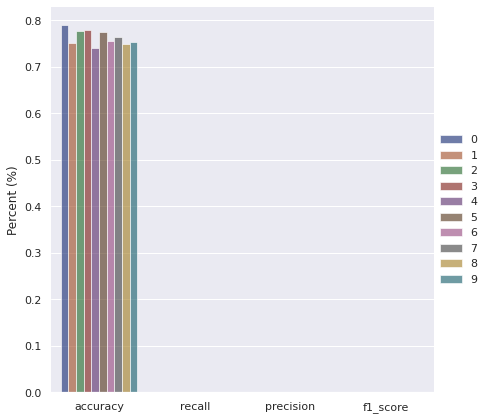

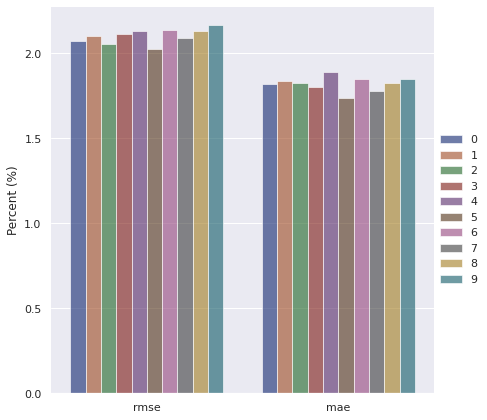

In [ ]:

eval = evaluator()
df = pd.DataFrame(columns=['user','metric','score'])
df2 = pd.DataFrame(columns=['user','metric','score'])
for u in range(10):
  model = cb_nn(input_user = u)
  grade_df = model.split_and_predict()
  a,b = eval.user_metric_df(user=u,df=grade_df,threshold=3)
  df = df.append(a)
  df2 = df2.append(b)

eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='user')

eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='user')


# **`cb_adaboost.py`**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor

class cb_adaboost():
  
  def __init__(self,input_user):
    self.input_user = input_user
    self.df = pd.read_pickle('/content/drive/My Drive/multi-user5.pkl')
    self.df = self.df.loc[self.df['UserId'] == input_user]
    self.df = self.df.drop_duplicates(subset='ImageSource',keep='first')
    self.prodNo = self.df['ProductNo'].tolist()
    self.ratings = self.df['gradeUser'].tolist()
    self.all_clothes = pd.read_pickle('/content/drive/My Drive/clothes_attr.pkl')
    self.rated_clothes = self.all_clothes.copy()
    self.rated_clothes['ratings'] = self.ratings
    

    z = []
    for i in range(4325):
      z.append([])

    for i in range(10):
      if i != self.input_user:
        rating_data = pd.read_pickle('/content/drive/My Drive/multi-user5.pkl')
        u_data = rating_data.loc[rating_data['UserId'] == i]
        u_data = u_data.drop_duplicates(subset='ImageSource',keep='first')
        for j in range(len(u_data)):
          if u_data.iloc[j]['gradeUser']!=2.5:
            z[j].append(u_data.iloc[j]['gradeUser'])
    for i in range(len(z)):
      if len(z[i])>0:
        z[i] = sum(z[i]) / len(z[i])
      else:
        z[i] = -1
    #self.rated_clothes['avg_rating'] = z
    self.unrated_clothes = self.rated_clothes.copy()
    self.unrated_clothes = self.unrated_clothes.loc[self.unrated_clothes['ratings'] ==2.5]
    self.rated_clothes = self.rated_clothes.loc[self.rated_clothes['ratings'] != 2.5]
    self.ratings = self.rated_clothes['ratings'].tolist()
    self.rated_clothes = self.rated_clothes.drop(columns='ratings')
    self.unrated_clothes = self.unrated_clothes.drop(columns='ratings')

  def recommend(self,itemsTopredict):
    # init regressor rf
    regr = AdaBoostRegressor(random_state=0, n_estimators=100)
    #regr = RandomForestRegressor(n_estimators=100,criterion='mse', random_state=1)
    # train 
    regr.fit(self.rated_clothes, self.ratings)
    # predict
    pred_X = self.unrated_clothes.loc[itemsTopredict]
    y_pred = regr.predict(pred_X)
    # result dataframe
    df = pd.DataFrame()
    df['clothId'] = pred_X.index.tolist()
    df['rf_pred'] = y_pred
   
    return df

  def split_and_predict(self):
    # init regressor rf
    regr = AdaBoostRegressor(random_state=0, n_estimators=80,base_estimator=RandomForestRegressor(max_depth=10))
    # split data
    train_X, test_X, train_y, test_y = train_test_split(self.rated_clothes, self.ratings, test_size=0.1, random_state=1)
    # train 
    regr.fit(train_X,train_y)
    # predict
    y_pred = regr.predict(test_X)
   
    # result dataframe
    df = pd.DataFrame(columns=['clothId','y_pred','y_true'])
    df['clothId'] = test_X.index.tolist()
    df['y_true'] = test_y
    df['y_pred'] = y_pred

    return df
 

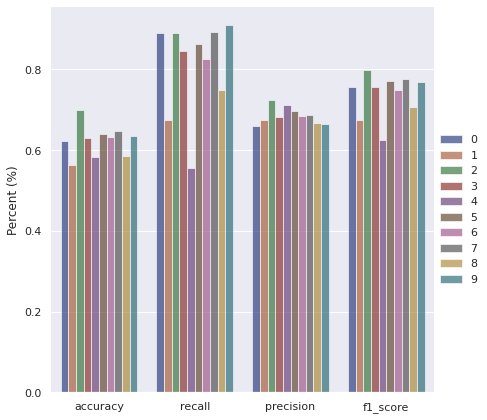

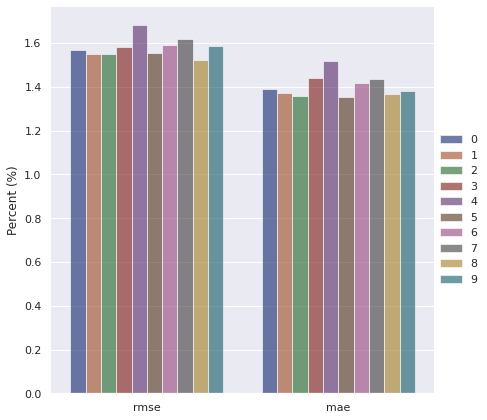

In [ ]:
eval = evaluator()
df = pd.DataFrame(columns=['user','metric','score'])
df2 = pd.DataFrame(columns=['user','metric','score'])
for u in range(10):
  model = cb_adaboost(input_user = u)
  grade_df = model.split_and_predict()
  a,b = eval.user_metric_df(user=u,df=grade_df,threshold=3)
  df = df.append(a)
  df2 = df2.append(b)

eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='user')

eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='user')

# **`hybrid.py`**

In [ ]:
class hybrid():
  def __init__(self,handler,input_user,dataset,cols):
    self.input_user = input_user
    self.dataset = dataset
    self.cols = cols
    cf_models = []
    # collaborative user based
    model = cf_userbased(dataset=dataset,columns=cols,input_user=input_user,max_neighbors=5)
    cf_models.append(model)
    # collaborative svd
    model = cf_svd(input_user,dataset,cols)
    cf_models.append(model)
    # collaborative deep learning
    preprocess_pack = handler.deep_preprocessing(dataset)
    model = cf_deep(preprocess_pack,handler,cols,input_user)
    cf_models.append(model)
    all_preds = []
    # collaborative based split
    train,test = handler.split(self.dataset,self.input_user,0.1)
    # collaborative pred
    for i in range(len(cf_models)):
      all_preds.append(cf_models[i].hyb_eval(train,test))
    # collaborative merge
    
    # content based split
    train_cb = train.copy()
    train_cb = train_cb.loc[train_cb['userId'] == input_user]
    test_cb = test.copy()
    test_cb = test_cb.loc[test_cb['userId'] == input_user]

    cb_models = []
    # content based neural network
    model = cb_nn(input_user)
    cb_models.append(model)
    model = cb_rf(input_user)
    cb_models.append(model)
    for i in range(len(cb_models)):
      all_preds.append(cb_models[i].hyb_eval(train_cb,test_cb))
    df = all_preds[0]
    for i in range(1,len(all_preds)):
      df = pd.merge(df,all_preds[i],on='clothId',how='inner')
    
    df2 = df.copy()
    df2 = df2.drop(columns='clothId')
    avg_grades = []
    for i in range(len(df2)):
      grades = np.array(df2.iloc[i].tolist())
      weights = np.array([2,2,2,3,3])
      indices = np.where(np.logical_not(np.isnan(grades)))[0]     
      avg_grades.append(np.average(grades[indices], weights=weights[indices]))
          
    df['mean'] = df.drop(columns='clothId').mean(axis=1)
    df['w_mean'] = avg_grades

    df = pd.merge(df,test[columns[1:3]],on='clothId',how='inner')
    self.df = df
    self.all_preds = all_preds
    self.test = test

In [ ]:
a = hybrid(handler,0,dataset,columns)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


82/84 [============================>.] - ETA: 0s - loss: 6.8645
Epoch 00001: val_loss improved from inf to 2.53955, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 3s 40ms/step - loss: 6.8081 - val_loss: 2.5396
Epoch 2/10
83/84 [============================>.] - ETA: 0s - loss: 3.2512
Epoch 00002: val_loss did not improve from 2.53955
84/84 [==============================] - 2s 22ms/step - loss: 3.2483 - val_loss: 2.7096
Epoch 3/10
10/84 [==>...........................] - ETA: 1s - loss: 3.1055

KeyboardInterrupt: ignored

In [ ]:
a.df

,clothId,ub_pred,svd_pred,dl_pred,nn_pred,rf_pred,mean,w_mean,rating
0,2177,4.441029,4.394982,4.234648,3.910507,2.832333,3.962700,3.864153,4.5
1,522,4.054147,4.144399,4.003092,3.917547,4.770000,4.177837,4.205493,5.0
2,1427,4.357463,3.979303,3.674349,3.281455,3.155000,3.689514,3.610966,5.0
3,3988,4.499326,4.517321,3.912384,3.630882,3.665000,4.044983,3.978809,5.0
4,404,4.872963,4.733000,4.876778,4.431194,4.555000,4.693787,4.660339,5.0
...,...,...,...,...,...,...,...,...,...
212,757,NaN,2.339065,2.594694,2.415756,2.490000,2.459879,2.458479,1.5
213,2618,NaN,3.272613,3.992215,3.828651,4.060000,3.788370,3.819561,5.0
214,876,NaN,3.352372,3.021569,3.636436,3.380000,3.347594,3.379719,5.0
215,298,NaN,4.513661,4.388918,3.776388,4.577500,4.314117,4.286682,1.5


In [ ]:
pred = a.df['mean']
true = a.df['rating']
mean_absolute_error(true,pred)

#pd.merge(aa,bb,on='clothId',how='inner')

1.2606976696492604

In [ ]:
pred

0      4.418006
1      4.099273
2      4.168383
3      4.508323
4      4.802982
         ...   
212    2.339065
213    3.272613
214    3.352372
215    4.513661
216    4.807876
Name: mean, Length: 217, dtype: float64

# **`cloth_preprocess.py`**

In [ ]:
data = pd.read_csv('/content/drive/My Drive/final.csv')
data.head(3)

,Unnamed: 0,UserId,ProductNo,Crawler,SearchWords,Image,url,ImageSource,SiteClothesHeadline,Color,Gender,Brand,Metadata,ProductCategory,ProductSubcategory,Length,Sleeve,CollarDesign,NeckDesign,Fit,gradeSystem,clicks,gradeUser,favorite,dashboard
0,0,0,0,Asos,SHORTSET,/home/alexandros/Desktop/createCsvDiplo/AsosIm...,https://www.asos.com/in-the-style/in-the-style...,https://images.asos-media.com/products/in-the-...,In The Style x Billie Faiers motif t shirt and...,White,WOMAN,In The Style,Collaboration with influencer Billie Faiers - ...,SET,"SHIRT,T-SHIRT",SHORT LENGTH,SHORT SLEEVE,NO COLLAR,ROUND NECK,RELAXED FIT,0,1,5,0,1
1,1,0,1,Asos,SHORTSET,/home/alexandros/Desktop/createCsvDiplo/AsosIm...,https://www.asos.com/bluebella/bluebella-abiga...,https://images.asos-media.com/products/bluebel...,Bluebella Abigail Satin Short Pyjama Set,Pink,WOMAN,BlueBella,You’re invited to this PJ party - Notch lapels...,SET,SET,SHORT LENGTH,SHORT SLEEVE,POLO COLLAR,COLLAR,REGULAR FIT,1,1,8,1,0
2,2,0,2,Asos,SHORTSET,/home/alexandros/Desktop/createCsvDiplo/AsosIm...,https://www.asos.com/chelsea-peers/chelsea-pee...,https://images.asos-media.com/products/chelsea...,Chelsea Peers stripe flamingo printed cami sho...,Multi,WOMAN,Chelsea Peers,Tonight's agenda: early night - V-neck - Adjus...,SET,SET,SHORT LENGTH,SLEEVELESS,NO COLLAR,V NECK,REGULAR FIT,2,1,5,0,0


In [ ]:
liked_df[3]

In [ ]:
import difflib
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

class recommendation_query():

  def __init__(self,df,input_user,models):
    self.input_user = input_user
    self.df = df 
    self.models = models

  def convert_index(self,old):
    id_db = pd.read_pickle('/content/drive/My Drive/id_db.pkl')
    new_list = id_db['id'].tolist()
    old_list = id_db['db_id'].tolist()
    new = []
    for j in range(len(old)):
      for i in range(len(id_db)):
        if old[j] in old_list[i]:
          new.append(new_list[i])
    return new

  def search(self):
    # available search words in dataset
    all_searchWords = self.df['SearchWords'].tolist()

    self.df = self.df.loc[self.df['UserId']==self.input_user]
    # make search words to lower case
    all_searchWords = [x.lower() for x in all_searchWords]

    # remove duplicate search words
    all_searchWords = set(all_searchWords)

    # user searching clothes category
    input_searchWords = input("Please enter your search words:  ")

   
    # find matches based on dataset searchwords
    matches = difflib.get_close_matches(input_searchWords, all_searchWords, len(all_searchWords) )
    self.matches = matches
    # print matches
    print('Result found: ',matches)
    
    # merge result of matches
    dataFrames = []
    for i in matches:
      dataFrames.append(self.df.loc[self.df['SearchWords'] == i.upper()])

    # all available clothes based on user search
    query_result = pd.concat(dataFrames)
    liked = query_result.loc[query_result['gradeUser'] >= 4]
    sw = liked['SearchWords'].tolist()
    prodNo = liked['ProductNo'].tolist()
    id = self.convert_index(prodNo)
    img_src = liked['ImageSource'].tolist()
    ldf = pd.DataFrame()
    ldf['SearchWords'] = sw
    ldf['clothId'] = id
    ldf['ImageSource'] = img_src

    query_result = query_result.loc[query_result['gradeUser'] ==2.5]
    sw = query_result['SearchWords'].tolist()
    prodNo = query_result['ProductNo'].tolist()
    img_src = query_result['ImageSource'].tolist()
    id = self.convert_index(prodNo)
    df = pd.DataFrame()
    df['SearchWords'] = sw
    df['clothId'] = id
    df['ImageSource'] = img_src
    return df,ldf


  def show_search(self):
    preds = []
    result,ldf = self.search()
    #print(result)
    print(len(result))
    for i in range(len(self.models)):
      preds.append(models[i].recommend(result['clothId'].unique()))
    df = preds[0]
    for i in range(1,len(preds)):
      df = pd.merge(df,preds[i],on='clothId',how='inner')
    df['mean'] = df.drop(columns='clothId').mean(axis=1)
    df = pd.merge(df,result,on='clothId')

    #print(df)
    #print(self.matches)
    liked_df = []
    
    
    matched_df = []
    for i in range(len(self.matches)):
     matched_df.append(df.loc[df['SearchWords'] == self.matches[i].upper()])
     liked_df.append(ldf.loc[ldf['SearchWords'] == self.matches[i].upper()])
    return matched_df,liked_df


  def show_rec(self,liked_df,matched_df):

    for i in range(3,4):
      #print('CATEGORY: ',self.matches[i])
      print('LIKED CLOTHES :')

      f_size = len(liked_df[i]) // 8
      print(f_size)
      print(len(liked_df[i]))
      if len(liked_df[i]) % 8 > 0:
        f_size += 1 
      print(f_size)
      fig, axs = plt.subplots(f_size, 8, sharex='col', sharey='row',figsize=(15,3*f_size),
                          gridspec_kw={'hspace': 0, 'wspace': 0})
      if f_size == 1:
        axs = np.expand_dims(axs, axis=0)
      x = np.linspace(0, 0 * np.pi, 300)
      y = np.sin(x ** 2)

      for j in range(f_size):
        for k in range(j*8,8*(j+1)):
          if (len(liked_df[i]) >= 8*(j+1)) or (len(liked_df[i]) > k):
            cloth = liked_df[i].iloc[k]
            rec_cloth = cloth['ImageSource']
            image = io.imread(rec_cloth)
            pos = k % 8
            axs[j][pos].imshow(image)
          else:
            axs[j][pos].plot(x,y)


      print('RECOMMENDED CLOTHES :')

      f_size = len(matched_df[i]) // 8
      print(f_size)
      print(len(matched_df[i]))
      if len(matched_df[i]) % 8 > 0:
        f_size += 1 
      print(f_size)
      fig, axs = plt.subplots(f_size, 8, sharex='col', sharey='row',figsize=(15,3*f_size),
                          gridspec_kw={'hspace': 0, 'wspace': 0})
      if f_size == 1:
        axs = np.expand_dims(axs, axis=0)
      x = np.linspace(0, 0 * np.pi, 300)
      y = np.sin(x ** 2)

      for j in range(f_size):
        for k in range(j*8,8*(j+1)):
          if (len(matched_df[i]) >= 8*(j+1)) or (len(matched_df[i]) > k):
            cloth = matched_df[i].iloc[k]
            rec_cloth = cloth['ImageSource']
            image = io.imread(rec_cloth)
            pos = k % 8
            axs[j][pos].imshow(image)
          else:
            axs[j][pos].plot(x,y)

     
'''      
    for i in range(4):
      cloth = liked_df[1].iloc[i]
      rec_cloth = cloth['ImageSource']
      print('-----------------')  
      image = io.imread(rec_cloth)
      plt.imshow(image)
      plt.show()
    for i in range(4):
      cloth = matched_df[1].iloc[i]
      rec_cloth = cloth['ImageSource']
      print('-----------------')  
      image = io.imread(rec_cloth)
      plt.imshow(image)
      plt.show()
'''

In [ ]:
models = []
# collaborative user based
model = cf_userbased(dataset,columns,0,1)
models.append(model)
# collaborative svd
model = cf_svd(0,dataset,columns)
models.append(model)
# content based random forest
model = cb_rf(input_user = 0)
models.append(model)
# adaboost random forest
#model = cb_adaboost(input_user = 0)
#models.append(model)

# data handler
handler = data_handler(path,columns)

# collaborative deep learning
preprocess_pack = handler.deep_preprocessing(dataset)
model = cf_deep(preprocess_pack,handler,columns,0)
models.append(model)


data =  pd.read_pickle('/content/drive/My Drive/multi-user5.pkl')

query = recommendation_query(data,0,models)

matched_df,liked_df = query.show_search()



Please enter your search words:  sleeve
Result found:  ['cupsleeveset', 'sleevelessset', 'longsleeveset', 'shortsleeveset', 'cupsleeveskirt', 'cupsleevedress']
63
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


83/84 [============================>.] - ETA: 0s - loss: 6.3705
Epoch 00001: val_loss improved from inf to 2.42882, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 29ms/step - loss: 6.3505 - val_loss: 2.4288
Epoch 2/10
84/84 [==============================] - ETA: 0s - loss: 3.3076
Epoch 00002: val_loss improved from 2.42882 to 2.38037, saving model to /content/drive/My Drive/models/weights_dl.hdf5
84/84 [==============================] - 2s 23ms/step - loss: 3.3076 - val_loss: 2.3804
Epoch 3/10
82/84 [============================>.] - ETA: 0s - loss: 2.9797
Epoch 00003: val_loss did not improve from 2.38037
84/84 [==============================] - 2s 23ms/step - loss: 2.9778 - val_loss: 2.3830
Epoch 4/10
83/84 [============================>.] - ETA: 0s - loss: 2.5739
Epoch 00004: val_loss did not improve from 2.38037
84/84 [==============================] - 2s 22ms/step - loss: 2.5725 - val_loss: 2.6248
Epoch 5/10
84/84 [=====

LIKED CLOTHES :
1
13
2
RECOMMENDED CLOTHES :
0
6
1


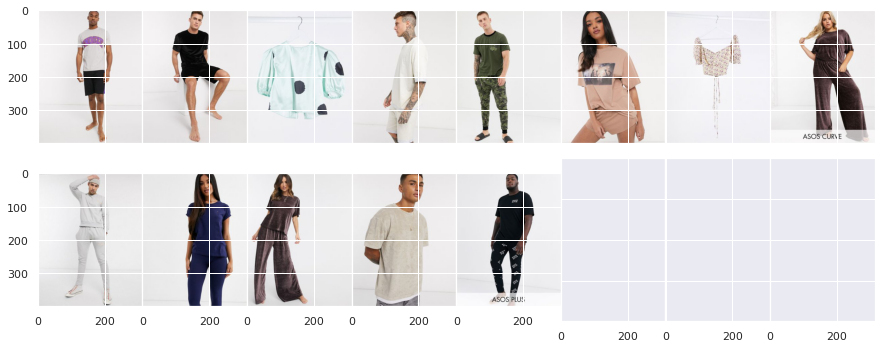

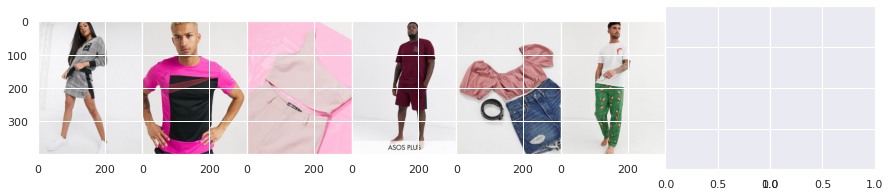

In [ ]:
query = recommendation_query(data,0,models)

query.show_rec(liked_df,matched_df)


In [ ]:
len(liked_df[1])

17

In [ ]:
len(liked_df[1])

17

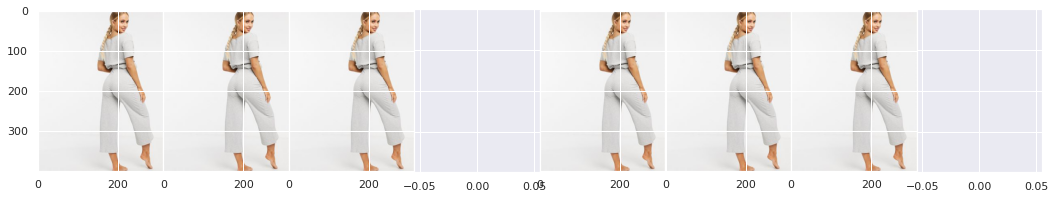

In [ ]:
fig, axs = plt.subplots(1, 8, sharex='col', sharey='row',figsize=(18,3),
                          gridspec_kw={'hspace': 0, 'wspace': 0})
x = np.linspace(0, 0 * np.pi, 300)

y = np.sin(x ** 2)
cloth = liked_df[1].iloc[0]
rec_cloth = cloth['ImageSource']
#print('-----------------')  
image = io.imread(rec_cloth)
#plt.imshow(image)
(ax1, ax2,ax3,ax4,ax5, ax6,ax7,ax8) = axs

ax1.imshow(image)
ax2.imshow(image)
ax3.imshow(image)
ax4.plot(x,y)
ax5.imshow(image)
ax6.imshow(image)
ax7.imshow(image)
ax8.plot(x,y)

In [ ]:
for i in matched_df:
  print(len(i))

8
11
1
17
19
8
4
1
9
2
9
16
1
0


In [ ]:
for i in preds:
  print(len(i))

86
86
86
86


In [ ]:
preds

df = preds[0]
for i in range(1,len(preds)):
  df = pd.merge(df,preds[i],on='clothId',how='inner')
df['mean'] = df.drop(columns='clothId').mean(axis=1)
pd.merge(df,r,on='clothId')

,clothId,ub_pred,svd_pred,rf_pred,dl_pred,mean,SearchWords,ImageSource
0,2,4.090833,4.202100,4.465,4.698110,4.364011,SHORTPYJAMAS,https://images.asos-media.com/products/chelsea...
1,2,4.090833,4.202100,4.465,4.698110,4.364011,CAPRIPYJAMAS,https://images.asos-media.com/products/chelsea...
2,4227,4.590833,3.073299,3.075,2.153950,3.223271,CAPRIPYJAMAS,https://images.asos-media.com/products/loungea...
3,4232,1.090833,1.417615,3.200,1.493310,1.800440,CAPRIPYJAMAS,https://images.asos-media.com/products/dorina-...
4,11,4.090833,2.708785,2.220,4.033151,3.263192,SHORTPYJAMAS,https://images.asos-media.com/products/in-the-...
...,...,...,...,...,...,...,...,...
101,4258,NaN,3.883915,2.810,3.438152,3.377356,CUPSLEEVEPYJAMAS,https://images.asos-media.com/products/asos-de...
102,4268,NaN,3.869420,4.305,4.826199,4.333540,CUPSLEEVEPYJAMAS,https://images.asos-media.com/products/le-brev...
103,4311,NaN,NaN,1.780,NaN,1.780000,CUPSLEEVEPYJAMAS,https://images.asos-media.com/products/le-brev...
104,4312,NaN,4.000000,4.520,4.585585,4.368528,CUPSLEEVEPYJAMAS,https://images.asos-media.com/products/le-brev...
